<a href="https://colab.research.google.com/github/h-gokul/HHAR-Using_HARnet/blob/master/HHAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages, Mount the drive and Navigate to Project Folder in drive

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import skew, kurtosis
from scipy.signal import hilbert
from multiprocessing import Pool, cpu_count
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dropout, Lambda
from keras.layers import BatchNormalization, UpSampling1D, UpSampling2D, LSTM,  merge, concatenate,Reshape

from keras.utils import to_categorical
import keras
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
# from scipy.misc import imresize #deprecated
import scipy.signal
from scipy.signal import cwt, decimate
import pywt
import os
#from keras_squeezenet import SqueezeNet
# from SqueezeNetModel import SqueezeNet
from keras import regularizers
from keras import backend as K

Using TensorFlow backend.


In [2]:
import os
from google.colab import drive 
drive.mount ("/content/gdrive")
os.chdir("/content/gdrive/My Drive/HHAR")
cwd = os.getcwd()   
# print the current directory 
print("Current working directory is:", cwd) 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Current working directory is: /content/gdrive/My Drive/HHAR


#DataExtraction based on sampling rates

In [0]:
df1= pd.read_csv("Phones_accelerometer.csv")
df1.columns

Index(['Index', 'Arrival_Time', 'Creation_Time', 'x', 'y', 'z', 'User',
       'Model', 'Device', 'gt'],
      dtype='object')

In [0]:
#nan_removal
print(df1['gt'].value_counts())
print(df1['gt'].unique())
df_=pd.DataFrame()
df_= df_.append(df1[df1['gt']== 'stand'])
df_= df_.append(df1[df1['gt']== 'sit'])
df_= df_.append(df1[df1['gt']== 'walk'])
df_= df_.append(df1[df1['gt']== 'bike'])
df_= df_.append(df1[df1['gt']== 'stairsup'])
df_= df_.append(df1[df1['gt']== 'stairsdown'])
print(df_['gt'].value_counts())
print(df_['gt'].unique())

walk          2192401
sit           1991919
stand         1851492
bike          1845557
stairsup      1782010
stairsdown    1615896
Name: gt, dtype: int64
['stand' nan 'sit' 'walk' 'stairsup' 'stairsdown' 'bike']
walk          2192401
sit           1991919
stand         1851492
bike          1845557
stairsup      1782010
stairsdown    1615896
Name: gt, dtype: int64
['stand' 'sit' 'walk' 'bike' 'stairsup' 'stairsdown']


In [0]:
# del df1
# Create dictionaries for activities , devices and users.
label_ = {}
dev_ = {}
user_ = {}

df_ = df_[df_['gt'] != 'null'] 

acts=df_['gt'].unique()
print(acts)
num_classes = len(acts)
for i, a in enumerate(acts):
  label_[a]= i  
print(label_) #dictionary for 6 activity classes

devices= df_['Device'].unique()
print(devices)
for i, dev in enumerate(devices):
  dev_[dev]= i  
print(dev_) #dictionary for 8 devices

users= df_['User'].unique()
print(users)
for i, user in enumerate(users):
  user_[user]= i  
print(user_) #dictionary for 9 users

['stand' 'sit' 'walk' 'bike' 'stairsup' 'stairsdown']
{'stand': 0, 'sit': 1, 'walk': 2, 'bike': 3, 'stairsup': 4, 'stairsdown': 5}
['nexus4_1' 'nexus4_2' 's3_1' 's3_2' 's3mini_1' 's3mini_2' 'samsungold_1'
 'samsungold_2']
{'nexus4_1': 0, 'nexus4_2': 1, 's3_1': 2, 's3_2': 3, 's3mini_1': 4, 's3mini_2': 5, 'samsungold_1': 6, 'samsungold_2': 7}
['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i']
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8}


In [0]:
#to see shape
stand = df_[df_['gt']=='stand'] ## in the entire dataframe, choose the stand class.
s32=stand[stand["Device"]=='s3_2'] ## inside the stand class, select  s3_2 device among others. 
user_a = s32[s32["User"]=='a'] ## inside s3_2 device, there is many users, we see user a 
print(user_a.shape) ## print the shape of user a in s3_2 in stand class.

testArray_a = np.array(user_a) #indexed as [row][column]
np.shape(testArray_a)

(28144, 10)


(28144, 10)

In [0]:
print(testArray_a[0])
print(df_.columns)

[0 1424696633914 274248797337000 -6.0525417 1.0821792 7.374141000000002
 'a' 's3' 's3_2' 'stand']
Index(['Index', 'Arrival_Time', 'Creation_Time', 'x', 'y', 'z', 'User',
       'Model', 'Device', 'gt'],
      dtype='object')


In [0]:
def MinWindowFn(device): ##chooses a the window size for downsampling(ie decimation) depending on device. 
    if str(device) == 'nexus4_1' or str(device) == 'nexus4_2':
      min_w = 400
    elif str(device) == 's3_1' or str(device) == 's3_2':
      min_w = 300
    elif str(device) == 's3mini_1' or str(device) == 's3mini_2':
      min_w = 200
    else:
      min_w = 100
    return min_w
  
def ExtractWindow(df,w): 
  window_count= df.shape[0]//w ## crops out a divisible portion from the available stream of accelerometer data. say if df.shape= 91k, w=400, window_count = 227 windows    
  n=window_count*w ## n =  no. of windows * w 
  df = df.iloc[0:n]   ## extract the divisible portion of the dataframe.
  return df

d_400=pd.DataFrame()
d_300=pd.DataFrame()
d_200=pd.DataFrame()
d_100=pd.DataFrame()
acctemp, devtemp, actstemp = [],[],[]
for a in acts:
  df_acts = df_[df_['gt']== a]
  for d in devices:
    df_dev = df_acts[df_acts['Device']== d ]
    for u in users:
      df_user = df_dev[df_dev['User'] == u]
      df_user.drop(columns=["Index",'Arrival_Time', 'Creation_Time',"Model"], axis=1 , inplace=True)
      wlen = MinWindowFn(d)
      if (df_user.shape[0]>wlen): 
        if wlen==400 : 
          d_400 =d_400.append( ExtractWindow(df_user,wlen))               
        elif wlen==300 : 
          d_300 = d_300.append( ExtractWindow(df_user,wlen))
        elif wlen==200 : 
          d_200 = d_200.append( ExtractWindow(df_user,wlen))
        else : 
          d_100 = d_100.append( ExtractWindow(df_user,wlen))
  print(f'{a} is Done')
print ("All data are arranged Devices and label wise.")


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


stand is Done
sit is Done
walk is Done
bike is Done
stairsup is Done
stairsdown is Done
All data are arranged Devices and label wise.


In [0]:
## print the total number of windows of data is available per user
print((d_400['User'].value_counts()/400))
print(d_300['User'].value_counts()/300)
print(d_200['User'].value_counts()/200)
print(d_100['User'].value_counts()/100)

path = os.getcwd() +'/'
d_400.to_csv(path+'d_400.csv',index=False)
d_300.to_csv(path+'d_300.csv',index=False)
d_200.to_csv(path+'d_200.csv',index=False)
d_100.to_csv(path+'d_100.csv',index=False)

i    1594.0
e    1566.0
f    1560.0
b    1543.0
d    1481.0
g    1479.0
a    1445.0
h    1411.0
c    1381.0
Name: User, dtype: float64
i    1052.0
b    1043.0
e    1033.0
g    1018.0
a     970.0
h     966.0
d     960.0
c     938.0
f     506.0
Name: User, dtype: float64
f    862.0
i    825.0
g    814.0
h    800.0
b    777.0
e    775.0
a    743.0
c    729.0
d    717.0
Name: User, dtype: float64
b    2284.0
f    2201.0
i    2184.0
e    2136.0
g    2131.0
h    2041.0
c    2022.0
a    1945.0
d    1943.0
Name: User, dtype: float64


# Decimation and Reshape

There are unequal sampling rates ranging from 200Hz to 50 Hz depending on the devices used. So these were already segregated based on Sampling rates and now the signals need to be decimated to 50Hz on a preprocessing stage. 


In [0]:
#Run this to  see the data shape

stand = d_300[d_300['gt']=='stand'] ## in the entire dataframe, choose the stand class.
s32=stand[stand["Device"]=='s3_1'] ## inside the stand class, select  s3_2 device among others. 
user_a = s32[s32["User"]=='f'] ## inside s3_2 device, there is many users, we see user a 
print(user_a.shape) ## print the shape of user a in s3_2 in stand class.
testArray_a = np.array(user_a) #indexed as [row][column]
np.shape(testArray_a)

In [0]:
os.chdir("/content/gdrive/My Drive/HHAR")
d_400 =  pd.read_csv('d_400.csv')
d_300 =  pd.read_csv('d_300.csv')
d_200 =  pd.read_csv('d_200.csv')
d_100 =  pd.read_csv('d_100.csv')

In [0]:
from collections import Counter

def Decimate(df,w):
  x_ = []
  y_ = []
  count_tot,count_d,count_a = 0,0,0
  wlen = w/100
  acts = (df['gt'].unique())
  devs = (df['Device'].unique())
  user = (df['User'].unique())
  for a in acts:
    df_act = df[df["gt"]==a]
    count_a=count_a+1
    for d in devs:
      df_dev = df_act[df_act["Device"]==d]
      count_d=count_d+1
      count_u=0
      for u in user:
        df_user = df_dev[df_dev['User']==u]
        count_tot=count_tot+1
        count_u=count_u+1
        if (df_user.shape[0]> wlen):
          x =  list(decimate(np.array(df_user['x']),int(wlen)))
          y =  list(decimate(np.array(df_user['y']),int(wlen)))
          z =  list(decimate(np.array(df_user['z']),int(wlen)))  
          ulabel = np.repeat(u,len(x)) 
          dlabel = np.repeat(d,len(x))
          alabel = np.repeat(a,len(x))
          x_temp = (np.vstack((x,y,z))).transpose()
          x_temp = x_temp.reshape(-1,100,3) # reshaping to a window
          y_temp = np.vstack((alabel,ulabel,dlabel)).transpose()
          y_temp = y_temp.reshape(-1,100,3)
          y_temp = y_temp[:,0,:] #creating corresponding labels
          if (count_tot == 1):
            x_ = x_temp
            y_ = y_temp
          else:
            x_ = np.vstack((x_,x_temp))
            y_ = np.vstack((y_,y_temp))
  return (np.array(x_),np.array(y_)) 


In [0]:
#All are decimated to equal sampling rates of 50 Hz
x_400,y_400 = Decimate(d_400,400)
x_300,y_300 = Decimate(d_300,300)
x_200,y_200 = Decimate(d_200,200)
x_100,y_100 = Decimate(d_100,100)

x = np.vstack((x_400,x_300,x_200,x_100))
y = np.vstack((y_400,y_300,y_200,y_100))

In [0]:
print(x.shape,y[:,0].shape) # Final X and Y of the dataset


(47875, 100, 3) (47875,)


In [0]:
path = os.getcwd() +'/'
np.save(path+'x',x)
np.save(path+'y',y)

# Discrete Wavelet Transformation of the Signals


In [0]:
path = os.getcwd() +'/'
x = np.load(path +'x.npy')
y = np.load(path +'y.npy')

In [4]:
print(x.shape,y[:,0].shape) # Final X and Y of the dataset

(47875, 100, 3) (47875,)


In [0]:
masterX = []
for i in range(len(x)):
    Xca, Xda = pywt.dwt(x[i].reshape((-1, 3))[:,0], 'db1', mode='periodic') #wavelet transform the examples (rows) of x
    Yca, Yda = pywt.dwt(x[i].reshape((-1, 3))[:,1], 'db1', mode='periodic') #wavelet transform the examples (rows) of y
    Zca, Zda = pywt.dwt(x[i].reshape((-1, 3))[:,2], 'db1', mode='periodic') #wavelet transform the examples (rows) of z
    #coef0 = np.vstack((Xca, Xda))
    #coef1 = np.vstack((Yca, Yda))
    #coef2 = np.vstack((Zca, Zda))
    coef = np.hstack((Xca, Yca, Zca)).reshape((-1, 50, 3))
    masterX.append((coef))
    # print (i)

In [0]:
masterX = np.array(masterX)
masterX = masterX.reshape(-1,50,3)
Y = y[:,0]

In [0]:

fit0 = StandardScaler().fit(masterX[:, :, 0])
masterX0 = fit0.transform(masterX[:, :, 0])

fit1 = StandardScaler().fit(masterX[:, :, 1])
masterX1 = fit1.transform(masterX[:, :, 1])

fit2 = StandardScaler().fit(masterX[:, :, 2])
masterX2 = fit2.transform(masterX[:, :, 2])

In [0]:
X = np.dstack((masterX0, masterX1, masterX2))

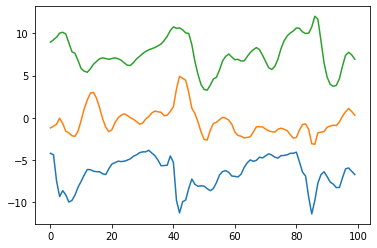

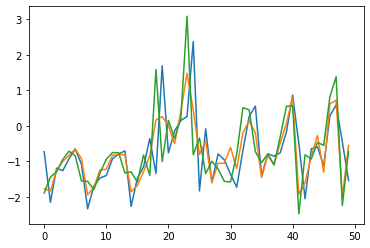

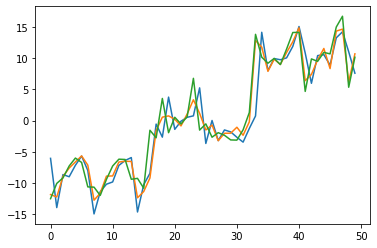

In [9]:
a = 42069 
plt.plot(x[a])
plt.show()
plt.plot(X[a])
plt.show()
plt.plot(masterX[a])
plt.show()

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=45)

In [11]:
onehot = pd.get_dummies(Y_train)
Y_labels_train = onehot.columns
Y_train = onehot.as_matrix()

onehot = pd.get_dummies(Y_test)
Y_labels_test = onehot.columns
Y_test = onehot.as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [12]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(33512, 50, 3) (14363, 50, 3) (33512, 6) (14363, 6)


In [0]:
# Making data Compatible for our HARNET architecture

X_train0 = X_train[:, :, 0].reshape((-1, 50, 1))
X_train1 = X_train[:, :, 1].reshape((-1, 50, 1))
X_train2 = X_train[:, :, 2].reshape((-1, 50, 1))

X_test0 = X_test[:, :, 0].reshape((-1, 50, 1))
X_test1 = X_test[:, :, 1].reshape((-1, 50, 1))
X_test2 = X_test[:, :, 2].reshape((-1, 50, 1))

# Creating the HARNET architecture.


In [0]:
y_ = pd.DataFrame(Y)
acts=y_[0].unique()
num_classes = len(acts)

In [14]:
# RNN 
#SUBNET X
input_layerX = Input(shape=(50,1))
layerX_2 = LSTM(32,return_sequences=True)(input_layerX)
convx_1 = Conv1D(8,(3),padding='same')(layerX_2)
batch_normx1 = BatchNormalization()(convx_1)
maxpx_1 = MaxPooling1D((2),padding='same')(batch_normx1)
final_layerX = maxpx_1

#SUBNET Y
input_layerY = Input(shape=(50,1))
layerY_2 = LSTM(32,return_sequences=True)(input_layerY)
convy_1 = Conv1D(8,(3),padding='same')(layerY_2)
batch_normy1 = BatchNormalization()(convy_1)
maxpy_1 = MaxPooling1D((2),padding='same')(batch_normy1)
final_layerY = maxpy_1

#SUBNET Z
input_layerZ = Input(shape=(50,1))
layerZ_2 = LSTM(32,return_sequences=True)(input_layerZ)
convz_1 = Conv1D(8,(3),padding='same')(layerZ_2)
batch_normz1 = BatchNormalization()(convz_1)
maxpz_1 = MaxPooling1D((2),padding='same')(batch_normz1)
final_layerZ = maxpz_1

#merge layers

merged_model = keras.layers.concatenate([final_layerX,final_layerY,final_layerZ],axis = 1)
print(K.int_shape(merged_model))

#CNN classifier

# final_merge = Reshape((K.int_shape(merged_model)[1]//3,3,1))(merged_model)
final_merge = Reshape((K.int_shape(merged_model)[1],K.int_shape(merged_model)[2],1))(merged_model)
conv_1 = Conv2D(8,(3,3),padding='same')(final_merge)
batch_norm1 = BatchNormalization()(conv_1)
pool_1 = MaxPooling2D((2,2),padding='same')(batch_norm1)

flatten = Flatten()(pool_1)

fc_layer1 = Dense(16,activation='relu')(flatten)

fc_layer2 = Dropout(0.25)(fc_layer1)

fc_layer3 = Dense(8,activation='relu')(fc_layer2)

fc_layer4 = Dropout(0.25)(fc_layer3)

output = Dense(num_classes,activation='softmax')(fc_layer4)

model = Model([input_layerX,input_layerY,input_layerZ],output)






(None, 75, 8)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50, 1)        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 50, 1)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 50, 32)       4352        input_1[0][0]                    
____________________________________________________________________________________________

# Training the Model


In [17]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=5e-4), metrics=['accuracy'])

In [22]:
model.fit([X_train0, X_train1, X_train2], Y_train, epochs=45, batch_size=512, \
          validation_data=([X_test0, X_test1, X_test2], Y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 33512 samples, validate on 14363 samples
Epoch 1/45
33512/33512 [==============================] - 37s 1ms/step - loss: 1.6938 - acc: 0.3080 - val_loss: 1.5561 - val_acc: 0.5192
Epoch 2/45
33512/33512 [==============================] - 33s 979us/step - loss: 1.5244 - acc: 0.4192 - val_loss: 1.3541 - val_acc: 0.6225
Epoch 3/45
33512/33512 [==============================] - 33s 979us/step - loss: 1.3897 - acc: 0.4566 - val_loss: 1.1768 - val_acc: 0.6603
Epoch 4/45
33512/33512 [==============================] - 33s 983us/step - loss: 1.2397 - acc: 0.5054 - val_loss: 1.0516 - val_acc: 0.6954
Epoch 5/45
33512/33512 [==============================] - 33s 985us/step - loss: 1.1303 - acc: 0.5566 - val_loss: 0.9235 - val_acc: 0.7499
Epoch 6/45
33512/33512 [==============================] - 33s 985us/step - loss: 1.0403 - acc: 0.6138 - val_loss: 0.8367 - val_acc: 0.7331
Epoch 7/45
33512/33512

In [0]:
preds = model.predict([X_test0,X_test1,X_test2],batch_size=32)
preds = to_categorical(np.argmax(preds,axis=1))

In [30]:
from sklearn.metrics import classification_report
print (classification_report(Y_test,preds))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2453
           1       0.94      1.00      0.97      2404
           2       0.88      0.83      0.85      2144
           3       0.83      0.93      0.88      2307
           4       0.96      0.94      0.95      2285
           5       0.92      0.89      0.91      2770

   micro avg       0.92      0.92      0.92     14363
   macro avg       0.92      0.92      0.92     14363
weighted avg       0.92      0.92      0.92     14363
 samples avg       0.92      0.92      0.92     14363

